In [105]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Electricity cost estimator for tomorrow based on weather and past prices

This project builds a robust, modular pipeline to estimate electricity prices for the next 24 hours (96 × 15min intervals) using weather forecasts, historical prices, and Fingrid power system data. The workflow includes:

- Data cleaning and merging (prices, weather, Fingrid)
- Feature engineering (lags, rolling, calendar, exogenous)
- Multi-output regression (tree-based and deep learning models)
- Model comparison, ensemble, and slice-wise error analysis
- Clear recommendations and ready-to-use code for production

All results, recommendations, and code are up-to-date as of November 2025.

# 1. Business Understanding

- **Goal:** Forecast the next 24 hours of electricity prices (15min resolution) using historical prices, weather forecasts, and Fingrid system data.
- **Stakeholders:** Households, businesses, and energy consumers optimizing usage or costs.
- **Key questions:**
  - How accurately can we predict day-ahead prices?
  - Which features and models provide the best performance?
  - How do models perform during high-price and peak periods?

## Success criteria
- **Quantitative:** MAE/RMSE below naïve baseline ("tomorrow = today").
- **Qualitative:** Model is maintainable, features are explainable, and results are actionable for end users.

# 2. Data Understanding – Datasets

**Main data sources:**

- **Price data (15 min):**
  - Quarter-hour Pörssisähkö prices (`price_ct_per_kwh`).
- **Weather data (hourly, 4 stations):**
  - Temperature, wind speed, rainfall, etc. from FMI.
- **Fingrid power system data:**
  - 15-min: total and wind generation
  - Hourly: total consumption

**Sources:**
- Price: Pörssisähkö API/CSV
- Weather: FMI open data
- Fingrid: Fingrid open data

Weather stations are chosen to represent western Finland, aligning with major wind generation areas.

# 3. Data Preparation – Raw data to modeling-ready table

We merge and clean all sources to produce a single 15‑minute resolution dataset, ready for feature engineering and modeling. Each transformation step is documented for reproducibility and transparency.

## 3.1 Load and inspect price data

- Load 15-min Pörssisähkö price data
- Parse timestamps, check structure and coverage
- Visualize for gaps or anomalies

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8")

data_dir = Path("data")
price_file = data_dir / "data_2024-11-22T0000_2025-11-22T0000.csv"

df_prices = (
    pd.read_csv(price_file, parse_dates=["timestamp_utc"])
      .sort_values("timestamp_utc")
      .reset_index(drop=True)
)

print("Price data shape:", df_prices.shape)
print(df_prices.dtypes)
print("Price time range:", df_prices["timestamp_utc"].min(), "→", df_prices["timestamp_utc"].max())
df_prices.head()

Price data shape: (35040, 2)
timestamp_utc       datetime64[ns, UTC]
price_ct_per_kwh                float64
dtype: object
Price time range: 2024-11-22 00:00:00+00:00 → 2025-11-21 23:45:00+00:00


,timestamp_utc,price_ct_per_kwh
0,2024-11-22 00:00:00+00:00,6.941
1,2024-11-22 00:15:00+00:00,6.941
2,2024-11-22 00:30:00+00:00,6.941
3,2024-11-22 00:45:00+00:00,6.941
4,2024-11-22 01:00:00+00:00,7.110


### Explore price time series

Visualize the 15‑minute spot prices to check for gaps, spikes, or flat segments. This helps ensure data quality before merging with other sources.

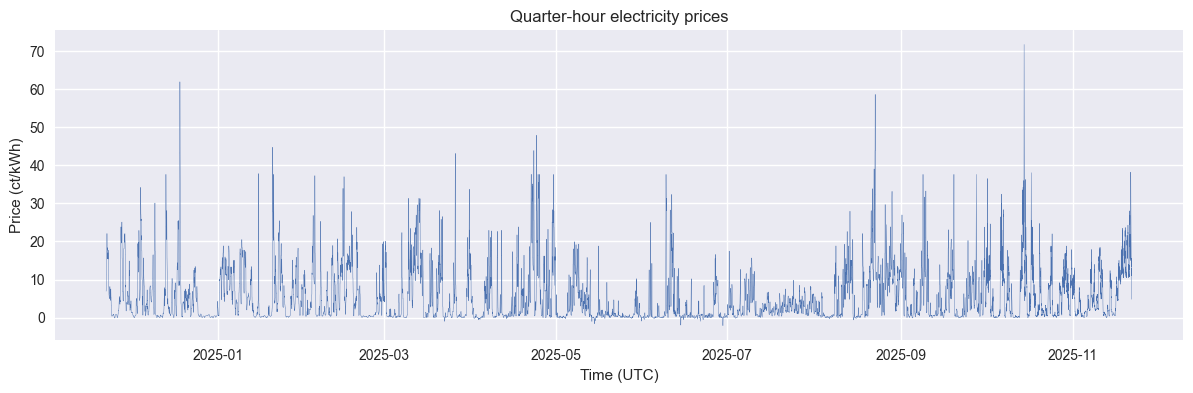

In [107]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_prices["timestamp_utc"], df_prices["price_ct_per_kwh"], linewidth=0.3)
ax.set_title("Quarter-hour electricity prices")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Price (ct/kWh)")
plt.tight_layout()
plt.show()

## 3.2 Load raw weather data from FMI

- Handle FMI's nonstandard CSV format
- Parse and clean weather data for all stations
- Combine into a single table for further processing

In [108]:
import pandas as pd
from pathlib import Path

data_dir = Path("data")

weather_files = [
    "Helsinki Kaisaniemi_ 22.11.2024 - 22.11.2025_3d3d41da-1d45-4c69-bacf-a114a7735389.csv",
    "Oulu lentoasema_ 22.11.2024 - 22.11.2025_f4fdc671-9da3-4780-a90c-f52844de5a3a.csv",
    "Pori lentoasema_ 22.11.2024 - 22.11.2025_71f03ff8-0cde-45a1-b39b-d44c9d5aff05.csv",
    "Vaasa lentoasema_ 22.11.2024 - 22.11.2025_86fe7b3e-156c-40f9-9be4-b2423b9448f5.csv",
]

dfs_weather = []

for fname in weather_files:
    path = data_dir / fname

    # Read raw with no header row; each row is literally the CSV line
    df_raw = pd.read_csv(path, sep=";", header=None, encoding="utf-8", dtype=str)

    # First row contains the real column names as a single string in col 0
    header_str = df_raw.iloc[0, 0]
    parts = [p.strip().strip('"') for p in header_str.split(",")]

    if len(parts) != 8:
        raise ValueError(f"Unexpected weather header format in {fname}: {parts}")

    # Remaining rows contain the data, still as a single string in col 0
    data_lines = df_raw.iloc[1:, 0].tolist()

    # Split each data line on commas, strip quotes, and build a DataFrame
    records = [[p.strip().strip('"') for p in line.split(",")] for line in data_lines]
    df_station = pd.DataFrame(records, columns=parts)

    df_station["source_file"] = fname
    dfs_weather.append(df_station)

df_weather_raw = pd.concat(dfs_weather, ignore_index=True)
print("Combined weather raw shape:", df_weather_raw.shape)
print(df_weather_raw.head())

Combined weather raw shape: (35093, 9)
         Havaintoasema Vuosi Kuukausi Päivä Aika [UTC]  \
0  Helsinki Kaisaniemi  2024       11    22      00:00   
1  Helsinki Kaisaniemi  2024       11    22      01:00   
2  Helsinki Kaisaniemi  2024       11    22      02:00   
3  Helsinki Kaisaniemi  2024       11    22      03:00   
4  Helsinki Kaisaniemi  2024       11    22      04:00   

  Lämpötilan keskiarvo [°C] Keskituulen nopeus [m/s] Tunnin sademäärä [mm]  \
0                      -0.1                      4.3                   0.1   
1                         0                      3.4                   0.4   
2                       0.2                      6.1                     0   
3                      -0.5                      5.8                   0.1   
4                      -0.9                      5.1                     0   

                                         source_file  
0  Helsinki Kaisaniemi_ 22.11.2024 - 22.11.2025_3...  
1  Helsinki Kaisaniemi_ 22.11.202

### Rename columns and construct timestamps

- Rename Finnish columns to English
- Build a proper UTC timestamp from year, month, day, and time
- Keep only relevant fields and sort by time

In [109]:
# Rename to simpler names
df_weather = df_weather_raw.rename(columns={
    "Havaintoasema": "station",
    "Vuosi": "year",
    "Kuukausi": "month",
    "Päivä": "day",
    "Aika [UTC]": "time_utc_str",
    "Lämpötilan keskiarvo [°C]": "temp_avg_c",
    "Keskituulen nopeus [m/s]": "wind_speed_ms",
    "Tunnin sademäärä [mm]": "rain_mm",
})

# Build timestamp_utc
dt_str = (
    df_weather["year"].astype(int).astype(str) + "-" +
    df_weather["month"].astype(int).astype(str).str.zfill(2) + "-" +
    df_weather["day"].astype(int).astype(str).str.zfill(2) + " " +
    df_weather["time_utc_str"].astype(str)
)

df_weather["timestamp_utc"] = pd.to_datetime(dt_str, utc=True, errors="coerce")

# Keep only needed cols
df_weather = (
    df_weather[["timestamp_utc", "station", "temp_avg_c", "wind_speed_ms", "rain_mm"]]
    .dropna(subset=["timestamp_utc"])
    .sort_values("timestamp_utc")
    .reset_index(drop=True)
)

print("After timestamp creation:", df_weather.shape)
df_weather.head()

After timestamp creation: (35093, 5)


,timestamp_utc,station,temp_avg_c,wind_speed_ms,rain_mm
0,2024-11-22 00:00:00+00:00,Helsinki Kaisaniemi,-0.1,4.3,0.1
1,2024-11-22 00:00:00+00:00,Oulu lentoasema,-2.7,5.6,-
2,2024-11-22 00:00:00+00:00,Vaasa lentoasema,-1.9,3,-
3,2024-11-22 00:00:00+00:00,Pori lentoasema,-0.9,3.7,-
4,2024-11-22 01:00:00+00:00,Vaasa lentoasema,-1.9,3.3,-


### Clean strange numeric values in weather data

- Replace junk values with NaN
- Parse as float or extract last numeric substring
- Convert weather columns to numeric for aggregation

In [110]:
# Clean and convert weather value columns to numeric
for col in ["temp_avg_c", "wind_speed_ms", "rain_mm"]:
    # Replace empty strings and obvious junk with NaN
    df_weather[col] = df_weather[col].replace(["", "-", "NaN", "nan"], pd.NA)

    # If there are concatenated values like "-0.1-2.7-1.9-0.9",
    # take the last numeric token (you can also choose first or average if you prefer)
    def fix_cell(val):
        if pd.isna(val):
            return pd.NA
        s = str(val).strip()
        # split on non-digit / minus / decimal characters
        parts = [p for p in s.replace(",", ".").split() if p]
        # fall back: try to parse the whole string; if that fails, extract the last numeric-like run
        try:
            return float(s.replace(",", "."))
        except ValueError:
            # crude extraction of last numeric substring
            nums = []
            cur = ""
            for ch in s:
                if ch.isdigit() or ch in "-.":
                    cur += ch
                else:
                    if cur:
                        nums.append(cur)
                        cur = ""
            if cur:
                nums.append(cur)
            if not nums:
                return pd.NA
            try:
                return float(nums[-1])
            except ValueError:
                return pd.NA

    df_weather[col] = df_weather[col].apply(fix_cell)
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce")

### Aggregate weather across stations to hourly series

- Take the mean across all stations for each hour
- Produce a clean, hourly weather dataset for modeling

In [111]:
df_weather_hourly = (
    df_weather
    .groupby("timestamp_utc", as_index=False)
    .agg({
        "temp_avg_c": "mean",
        "wind_speed_ms": "mean",
        "rain_mm": "mean",
    })
    .sort_values("timestamp_utc")
    .reset_index(drop=True)
)

print("Aggregated hourly weather shape:", df_weather_hourly.shape)
df_weather_hourly.head()

Aggregated hourly weather shape: (8775, 4)


,timestamp_utc,temp_avg_c,wind_speed_ms,rain_mm
0,2024-11-22 00:00:00+00:00,-1.400,4.150,0.1
1,2024-11-22 01:00:00+00:00,-1.300,3.950,0.4
2,2024-11-22 02:00:00+00:00,-1.300,4.525,0.0
3,2024-11-22 03:00:00+00:00,-1.575,4.450,0.1
4,2024-11-22 04:00:00+00:00,-1.650,4.200,0.0


### Visual sanity check for hourly weather

Plot hourly temperature, wind speed, and rainfall to verify aggregation and spot outliers or missing data.

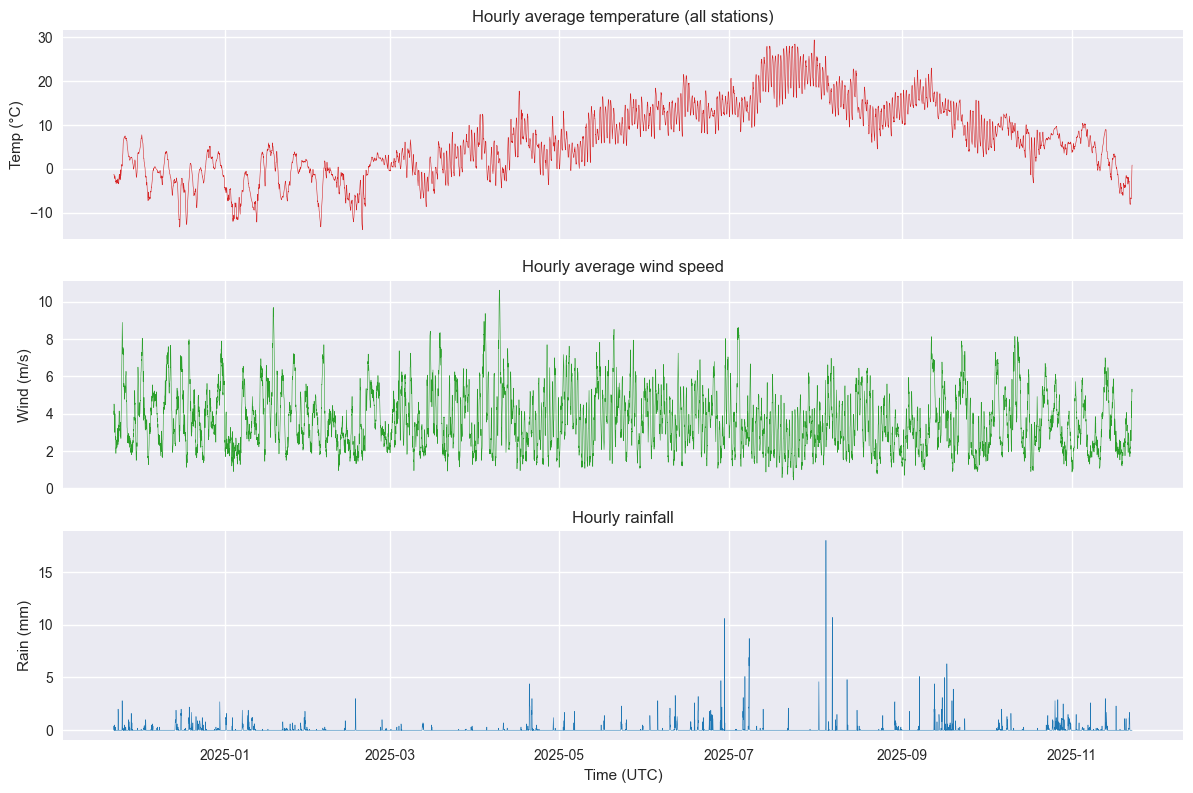

In [112]:
# Quick sanity plots for hourly weather (aggregated across stations)
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(
    df_weather_hourly["timestamp_utc"],
    df_weather_hourly["temp_avg_c"],
    linewidth=0.4,
    color="tab:red",
)
axes[0].set_ylabel("Temp (°C)")
axes[0].set_title("Hourly average temperature (all stations)")

axes[1].plot(
    df_weather_hourly["timestamp_utc"],
    df_weather_hourly["wind_speed_ms"],
    linewidth=0.4,
    color="tab:green",
)
axes[1].set_ylabel("Wind (m/s)")
axes[1].set_title("Hourly average wind speed")

axes[2].plot(
    df_weather_hourly["timestamp_utc"],
    df_weather_hourly["rain_mm"],
    linewidth=0.4,
    color="tab:blue",
)
axes[2].set_ylabel("Rain (mm)")
axes[2].set_title("Hourly rainfall")
axes[2].set_xlabel("Time (UTC)")

plt.tight_layout()
plt.show()

### Upsample hourly weather to 15‑minute grid

- Resample hourly weather to 15-min intervals
- Forward-fill within each hour
- Aligns weather data with price data for merging

In [113]:
# Upsample hourly weather to 15-minute resolution (forward-fill within the hour)
df_weather_15min = (
    df_weather_hourly
    .set_index("timestamp_utc")
    .resample("15min")
    .ffill()
    .reset_index()
)

print("15-min weather shape:", df_weather_15min.shape)
df_weather_15min.head()

15-min weather shape: (35097, 4)


,timestamp_utc,temp_avg_c,wind_speed_ms,rain_mm
0,2024-11-22 00:00:00+00:00,-1.4,4.15,0.1
1,2024-11-22 00:15:00+00:00,-1.4,4.15,0.1
2,2024-11-22 00:30:00+00:00,-1.4,4.15,0.1
3,2024-11-22 00:45:00+00:00,-1.4,4.15,0.1
4,2024-11-22 01:00:00+00:00,-1.3,3.95,0.4


## 3.3 Combine prices and weather on 15‑minute grid

Merge 15-min price and weather data on timestamp. Resulting table contains price and weather features for each interval.

In [114]:
# Merge 15-min price data with 15-min weather data
df_price_weather = df_prices.merge(
    df_weather_15min,
    on="timestamp_utc",
    how="left",
)

print("Price + weather shape:", df_price_weather.shape)
df_price_weather.head()

Price + weather shape: (35040, 5)


,timestamp_utc,price_ct_per_kwh,temp_avg_c,wind_speed_ms,rain_mm
0,2024-11-22 00:00:00+00:00,6.941,-1.4,4.15,0.1
1,2024-11-22 00:15:00+00:00,6.941,-1.4,4.15,0.1
2,2024-11-22 00:30:00+00:00,6.941,-1.4,4.15,0.1
3,2024-11-22 00:45:00+00:00,6.941,-1.4,4.15,0.1
4,2024-11-22 01:00:00+00:00,7.110,-1.3,3.95,0.4


### Zoomed view: price vs. weather

Plot a one-week window to visually compare price, temperature, wind, and rainfall. This helps understand short-term relationships and data alignment.

Zoomed range: 2025-01-01 00:00:00+00:00 → 2025-01-07 23:45:00+00:00
Zoomed shape: (672, 5)


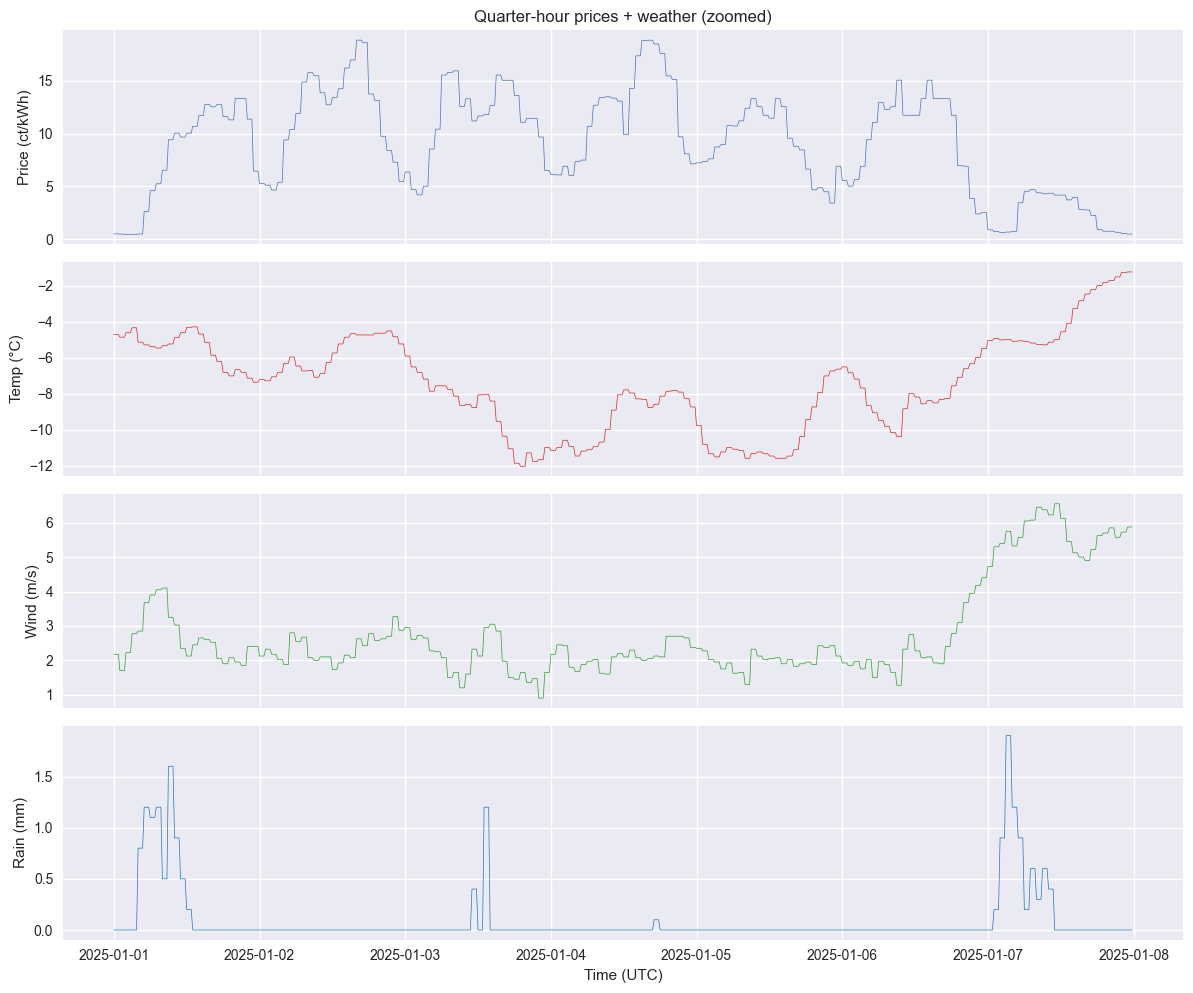

In [115]:
# Pick a smaller time window to zoom in
start_zoom = pd.Timestamp("2025-01-01", tz="UTC")
end_zoom   = pd.Timestamp("2025-01-08", tz="UTC")

mask = (df_price_weather["timestamp_utc"] >= start_zoom) & (
    df_price_weather["timestamp_utc"] < end_zoom
)
df_zoom = df_price_weather.loc[mask].copy()

print("Zoomed range:", df_zoom["timestamp_utc"].min(), "→", df_zoom["timestamp_utc"].max())
print("Zoomed shape:", df_zoom.shape)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1) Price
axes[0].plot(
    df_zoom["timestamp_utc"],
    df_zoom["price_ct_per_kwh"],
    linewidth=0.5,
)
axes[0].set_ylabel("Price (ct/kWh)")
axes[0].set_title("Quarter-hour prices + weather (zoomed)")

# 2) Temperature
axes[1].plot(
    df_zoom["timestamp_utc"],
    df_zoom["temp_avg_c"],
    linewidth=0.5,
    color="tab:red",
)
axes[1].set_ylabel("Temp (°C)")

# 3) Wind
axes[2].plot(
    df_zoom["timestamp_utc"],
    df_zoom["wind_speed_ms"],
    linewidth=0.5,
    color="tab:green",
)
axes[2].set_ylabel("Wind (m/s)")

# 4) Rain
axes[3].plot(
    df_zoom["timestamp_utc"],
    df_zoom["rain_mm"],
    linewidth=0.5,
    color="tab:blue",
)
axes[3].set_ylabel("Rain (mm)")
axes[3].set_xlabel("Time (UTC)")

plt.tight_layout()
plt.show()

## 3.4 Load Fingrid power system data

- Load and inspect Fingrid CSV (generation, wind, consumption)
- Parse timestamps and values
- Prepare for merging with price and weather data

In [116]:
from pathlib import Path

fingrid_file = data_dir / "fingrid_data_2024-11-22T0000_2025-11-22T0000.csv"

# First attempt: semicolon-separated, common for Fingrid exports
df_fingrid = pd.read_csv(
    fingrid_file,
    sep=";",
    engine="python",
    encoding="utf-8",
)

print("Fingrid raw shape:", df_fingrid.shape)
print(df_fingrid.columns.tolist())
df_fingrid.head(10)

Fingrid raw shape: (78606, 5)
['datasetId', 'startTime', 'endTime', 'value', 'additionalJson']


,datasetId,startTime,endTime,value,additionalJson
0,74,2025-11-21T21:45:00.000Z,2025-11-21T22:00:00.000Z,9758.23,NaN
1,75,2025-11-21T21:45:00.000Z,2025-11-21T22:00:00.000Z,1540.09,NaN
2,74,2025-11-21T21:30:00.000Z,2025-11-21T21:45:00.000Z,9715.73,NaN
3,75,2025-11-21T21:30:00.000Z,2025-11-21T21:45:00.000Z,1493.92,NaN
4,74,2025-11-21T21:15:00.000Z,2025-11-21T21:30:00.000Z,9783.39,NaN
5,75,2025-11-21T21:15:00.000Z,2025-11-21T21:30:00.000Z,1433.79,NaN
6,74,2025-11-21T21:00:00.000Z,2025-11-21T21:15:00.000Z,9878.06,NaN
7,75,2025-11-21T21:00:00.000Z,2025-11-21T21:15:00.000Z,1396.43,NaN
8,74,2025-11-21T20:45:00.000Z,2025-11-21T21:00:00.000Z,9766.63,NaN
9,75,2025-11-21T20:45:00.000Z,2025-11-21T21:00:00.000Z,1371.36,NaN


### Parse Fingrid timestamps and values

- Convert startTime to UTC timestamp
- Ensure values are numeric
- Drop rows with missing timestamps or values

In [117]:
# Parse timestamps and keep core columns
df_fingrid_clean = df_fingrid.copy()

# Use startTime as the time stamp (it’s a 15-min or 1-hour period start)
df_fingrid_clean["timestamp_utc"] = pd.to_datetime(
    df_fingrid_clean["startTime"], utc=True, errors="coerce"
)

# Make sure value is numeric
df_fingrid_clean["value"] = pd.to_numeric(df_fingrid_clean["value"], errors="coerce")

# Drop rows without a timestamp or value
df_fingrid_clean = df_fingrid_clean.dropna(subset=["timestamp_utc", "value"])

print("After basic cleaning:", df_fingrid_clean.shape)
df_fingrid_clean.head()

After basic cleaning: (78606, 6)


,datasetId,startTime,endTime,value,additionalJson,timestamp_utc
0,74,2025-11-21T21:45:00.000Z,2025-11-21T22:00:00.000Z,9758.23,NaN,2025-11-21 21:45:00+00:00
1,75,2025-11-21T21:45:00.000Z,2025-11-21T22:00:00.000Z,1540.09,NaN,2025-11-21 21:45:00+00:00
2,74,2025-11-21T21:30:00.000Z,2025-11-21T21:45:00.000Z,9715.73,NaN,2025-11-21 21:30:00+00:00
3,75,2025-11-21T21:30:00.000Z,2025-11-21T21:45:00.000Z,1493.92,NaN,2025-11-21 21:30:00+00:00
4,74,2025-11-21T21:15:00.000Z,2025-11-21T21:30:00.000Z,9783.39,NaN,2025-11-21 21:15:00+00:00


### Inspect available Fingrid series (datasetId)

- Check which variables are present and their frequency
- Identify 15-min and hourly series for further processing

In [118]:
df_fingrid_clean["datasetId"].value_counts()

datasetId
74     34949
75     34943
363     8714
Name: count, dtype: int64

### Map dataset IDs and pivot to wide format

- Map datasetId to human-readable names (generation, wind, consumption)
- Pivot to wide format: one row per timestamp, columns for each series

In [119]:
# Map datasetId → human-readable column name.
# UPDATE THESE IDs based on the value_counts output.
dataset_id_to_name = {
    74: "gen_total_mw",
    75: "gen_wind_mw",
    363: "cons_total_mw",
}

# Filter only the IDs you care about
df_fingrid_sel = df_fingrid_clean[
    df_fingrid_clean["datasetId"].isin(dataset_id_to_name.keys())
].copy()

# Replace datasetId with readable names
df_fingrid_sel["series"] = df_fingrid_sel["datasetId"].map(dataset_id_to_name)

# Pivot to wide: one row per timestamp, columns per series
df_fingrid_wide = df_fingrid_sel.pivot_table(
    index="timestamp_utc",
    columns="series",
    values="value",
    aggfunc="mean",
).sort_index()

df_fingrid_wide = df_fingrid_wide.reset_index()

print("Wide Fingrid shape:", df_fingrid_wide.shape)
df_fingrid_wide.head()

Wide Fingrid shape: (34967, 4)


series,timestamp_utc,cons_total_mw,gen_total_mw,gen_wind_mw
0,2024-11-21 22:00:00+00:00,6341537.654,10281.6,3833.74
1,2024-11-21 22:15:00+00:00,NaN,10254.4,3847.29
2,2024-11-21 22:30:00+00:00,NaN,10220.1,3858.16
3,2024-11-21 22:45:00+00:00,NaN,10128.4,3753.78
4,2024-11-21 23:00:00+00:00,6063308.210,10195.4,3701.63


### Align Fingrid generation and consumption to 15‑minute grid

- Keep generation at 15-min resolution
- Upsample hourly consumption to 15-min (forward-fill)
- Merge all series for consistent modeling

In [120]:
# Separate 15-min series (generation) and hourly series (consumption)
df_fingrid_15_src = df_fingrid_wide[["timestamp_utc", "gen_total_mw", "gen_wind_mw"]].copy()

# Upsample hourly consumption to 15-min and forward-fill within the hour
df_fingrid_cons_15 = (
    df_fingrid_wide[["timestamp_utc", "cons_total_mw"]]
    .set_index("timestamp_utc")
    .resample("15min")
    .ffill()
    .reset_index()
)

# Merge them back together on timestamp_utc
df_fingrid_15min = df_fingrid_15_src.merge(
    df_fingrid_cons_15,
    on="timestamp_utc",
    how="left",
)

print("Fingrid 15-min shape:", df_fingrid_15min.shape)
df_fingrid_15min.head()

Fingrid 15-min shape: (34967, 4)


series,timestamp_utc,gen_total_mw,gen_wind_mw,cons_total_mw
0,2024-11-21 22:00:00+00:00,10281.6,3833.74,6341537.654
1,2024-11-21 22:15:00+00:00,10254.4,3847.29,NaN
2,2024-11-21 22:30:00+00:00,10220.1,3858.16,NaN
3,2024-11-21 22:45:00+00:00,10128.4,3753.78,NaN
4,2024-11-21 23:00:00+00:00,10195.4,3701.63,6063308.210


## 3.5 Build the full modeling dataset

Merge price, weather, and Fingrid data into a single 15-min table. This is the foundation for all feature engineering and modeling steps.

In [121]:
df_full = df_price_weather.merge(
    df_fingrid_15min,
    on="timestamp_utc",
    how="left",
)

print("Full dataset shape (price + weather + generation):", df_full.shape)
df_full.head()

Full dataset shape (price + weather + generation): (35040, 8)


,timestamp_utc,price_ct_per_kwh,temp_avg_c,wind_speed_ms,rain_mm,gen_total_mw,gen_wind_mw,cons_total_mw
0,2024-11-22 00:00:00+00:00,6.941,-1.4,4.15,0.1,10038.60,3671.70,5901238.656
1,2024-11-22 00:15:00+00:00,6.941,-1.4,4.15,0.1,9983.39,3617.88,NaN
2,2024-11-22 00:30:00+00:00,6.941,-1.4,4.15,0.1,9961.96,3571.76,NaN
3,2024-11-22 00:45:00+00:00,6.941,-1.4,4.15,0.1,9959.98,3485.85,NaN
4,2024-11-22 01:00:00+00:00,7.110,-1.3,3.95,0.4,9894.21,3383.98,5791259.761


### Handle small gaps and final sanity check

- Fill small gaps in generation/consumption
- Visualize all features for a one-week window
- Ensure data is ready for feature engineering

gen_total_mw     0.0
gen_wind_mw      0.0
cons_total_mw    0.0
dtype: float64
Zoom non-null consumption rows: 672


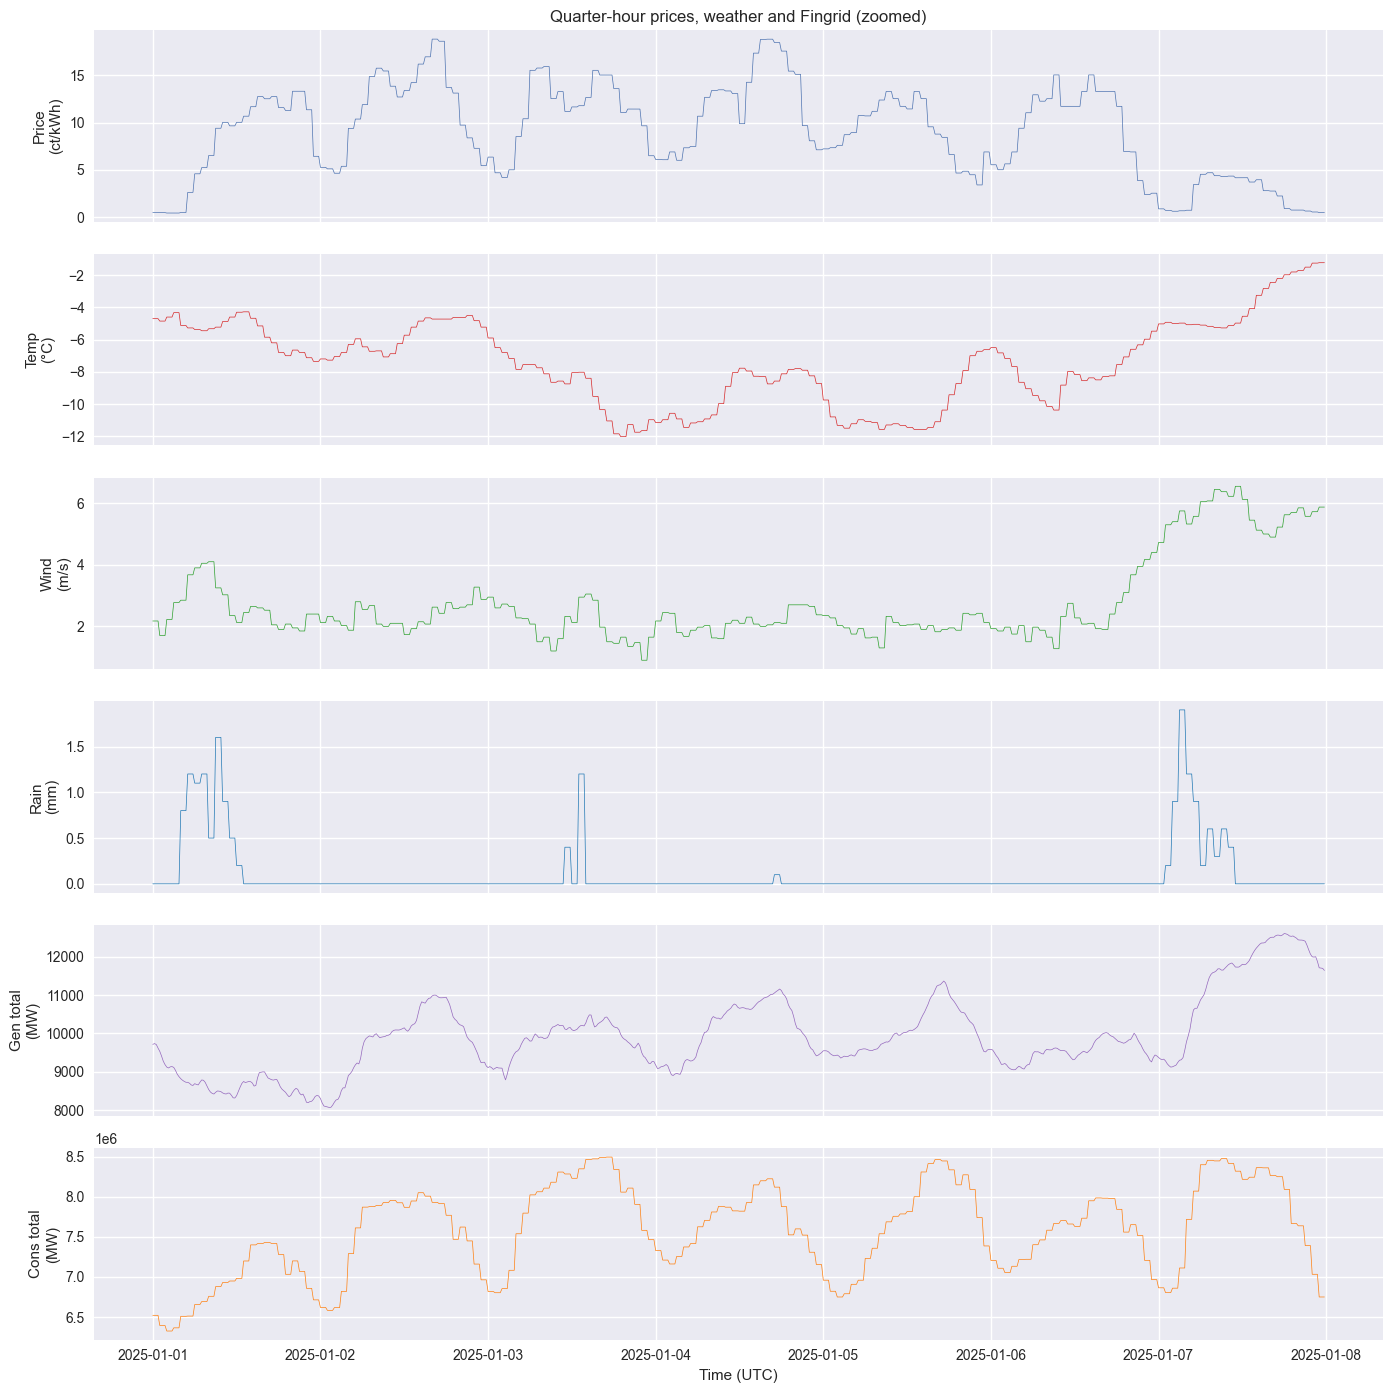

In [122]:
# Fill consumption and generation gaps for visualization / modeling
df_full = df_full.sort_values("timestamp_utc").reset_index(drop=True)

for col in ["gen_total_mw", "gen_wind_mw", "cons_total_mw"]:
    # First forward/backward fill as before
    df_full[col] = df_full[col].ffill().bfill()
    # If there are still any NaNs (e.g. at extreme edges), fill with global median
    if df_full[col].isna().any():
        df_full[col] = df_full[col].fillna(df_full[col].median())

print(df_full[["gen_total_mw", "gen_wind_mw", "cons_total_mw"]].isna().mean())

# Rebuild zoomed view (same dates as before)
start_zoom = pd.Timestamp("2025-01-01", tz="UTC")
end_zoom   = pd.Timestamp("2025-01-08", tz="UTC")

mask = (df_full["timestamp_utc"] >= start_zoom) & (df_full["timestamp_utc"] < end_zoom)
df_zoom_full = df_full.loc[mask].copy()

print("Zoom non-null consumption rows:", df_zoom_full["cons_total_mw"].notna().sum())

fig, axes = plt.subplots(6, 1, figsize=(14, 14), sharex=True)

axes[0].plot(df_zoom_full["timestamp_utc"], df_zoom_full["price_ct_per_kwh"], linewidth=0.5)
axes[0].set_ylabel("Price\n(ct/kWh)")
axes[0].set_title("Quarter-hour prices, weather and Fingrid (zoomed)")

axes[1].plot(df_zoom_full["timestamp_utc"], df_zoom_full["temp_avg_c"], linewidth=0.5, color="tab:red")
axes[1].set_ylabel("Temp\n(°C)")

axes[2].plot(df_zoom_full["timestamp_utc"], df_zoom_full["wind_speed_ms"], linewidth=0.5, color="tab:green")
axes[2].set_ylabel("Wind\n(m/s)")

axes[3].plot(df_zoom_full["timestamp_utc"], df_zoom_full["rain_mm"], linewidth=0.5, color="tab:blue")
axes[3].set_ylabel("Rain\n(mm)")

axes[4].plot(df_zoom_full["timestamp_utc"], df_zoom_full["gen_total_mw"], linewidth=0.5, color="tab:purple")
axes[4].set_ylabel("Gen total\n(MW)")

axes[5].plot(df_zoom_full["timestamp_utc"], df_zoom_full["cons_total_mw"], linewidth=0.5, color="tab:orange")
axes[5].set_ylabel("Cons total\n(MW)")
axes[5].set_xlabel("Time (UTC)")

plt.tight_layout()
plt.show()

## 4. Modeling – Multi-Step Targets and Features

With the full 15‑minute dataset, we:

1. Define 24-hour (96 × 15min) multi-step targets
2. Engineer lags, rolling, calendar, weather, and Fingrid features
3. Split into train/validation sets (time order preserved)
4. Train and evaluate multi-output models vs. baseline

### 4.1 Define 24h (96x 15min) Multi-Step Targets and Features

- Create 96 future target columns (one for each 15-min step)
- Engineer lag, rolling, exogenous, and calendar features
- Split for time series modeling
- Ensure data is ready for multi-output regression

In [123]:
# 4.1 Define prediction target and basic features

# We assume df_full already exists and is cleaned
df_model = df_full.copy()

# Ensure time is sorted and set index for convenience
df_model = df_model.sort_values("timestamp_utc").reset_index(drop=True)
df_model = df_model.set_index("timestamp_utc")

# --- Target: next 1-hour average price (4x 15-min ahead) ---

# Rolling mean of the next 4 quarters as the future 1h price
# We shift by -4 to look forward in time
df_model["target_price_1h_ahead"] = (
    df_model["price_ct_per_kwh"]
    .rolling(window=4, min_periods=4)
    .mean()
    .shift(-4)
)

# --- Price history features (lags and rolling means) ---

# Simple lags: last 4 quarters (1 hour)
for lag in [1, 2, 3, 4]:
    df_model[f"price_lag_{lag}"] = df_model["price_ct_per_kwh"].shift(lag)

# Rolling mean of past 1h (4 quarters) and 4h (16 quarters)
df_model["price_roll_mean_1h"] = (
    df_model["price_ct_per_kwh"].rolling(window=4, min_periods=4).mean()
)
df_model["price_roll_mean_4h"] = (
    df_model["price_ct_per_kwh"].rolling(window=16, min_periods=8).mean()
)

# --- Weather and Fingrid lags (short-term history) ---

for col in ["temp_avg_c", "wind_speed_ms", "rain_mm",
            "gen_total_mw", "gen_wind_mw", "cons_total_mw"]:
    df_model[f"{col}_lag_1"] = df_model[col].shift(1)
    df_model[f"{col}_lag_4"] = df_model[col].shift(4)

# --- Calendar features ---

df_model["hour"] = df_model.index.hour
df_model["dayofweek"] = df_model.index.dayofweek  # 0=Mon, 6=Sun
df_model["is_weekend"] = (df_model["dayofweek"] >= 5).astype(int)

# Drop rows where the target is NaN (end of series) or lags are missing
cols_required = ["target_price_1h_ahead"] + [
    c for c in df_model.columns if c.startswith("price_lag_")
]
df_model = df_model.dropna(subset=cols_required)

# As a final safety step, drop any rows that still have NaNs in any feature
df_model = df_model.dropna()

print("Model dataset shape:", df_model.shape)
df_model.head()

Model dataset shape: (35029, 29)


,price_ct_per_kwh,temp_avg_c,wind_speed_ms,rain_mm,gen_total_mw,gen_wind_mw,cons_total_mw,target_price_1h_ahead,price_lag_1,price_lag_2,...,rain_mm_lag_4,gen_total_mw_lag_1,gen_total_mw_lag_4,gen_wind_mw_lag_1,gen_wind_mw_lag_4,cons_total_mw_lag_1,cons_total_mw_lag_4,hour,dayofweek,is_weekend
timestamp_utc,,,,,,,,,,,,,,,,,,,,,
2024-11-22 01:45:00+00:00,7.110,-1.3,3.950,0.4,9680.88,3140.77,5791259.761,8.37600,7.110,7.110,...,0.1,9758.39,9959.98,3243.51,3485.85,5791259.761,5901238.656,1,4,0
2024-11-22 02:00:00+00:00,8.376,-1.3,4.525,0.0,9698.78,3059.66,5794689.099,8.62475,7.110,7.110,...,0.4,9680.88,9894.21,3140.77,3383.98,5791259.761,5791259.761,2,4,0
2024-11-22 02:15:00+00:00,8.376,-1.3,4.525,0.0,9739.16,2982.32,5794689.099,8.87350,8.376,7.110,...,0.4,9698.78,9758.39,3059.66,3243.51,5794689.099,5791259.761,2,4,0
2024-11-22 02:30:00+00:00,8.376,-1.3,4.525,0.0,9545.45,2766.27,5794689.099,9.12225,8.376,8.376,...,0.4,9739.16,9758.39,2982.32,3243.51,5794689.099,5791259.761,2,4,0
2024-11-22 02:45:00+00:00,8.376,-1.3,4.525,0.0,9416.72,2594.02,5794689.099,9.37100,8.376,8.376,...,0.4,9545.45,9680.88,2766.27,3140.77,5794689.099,5791259.761,2,4,0


### 4.2 Train / validation split and baselines

- Split data into training and validation periods (no shuffling)
- Create a naïve baseline (current price as forecast)
- Compare all models against this baseline

In [124]:
# Refactored: Prepare 24h (96x 15min) Multi-Step Targets and Features, Train/Validation Split

# 1. Create 96 future target columns (one for each 15min step)
target_cols = [f"target_t+{step}" for step in range(1, 97)]
targets = pd.DataFrame({
    f"target_t+{step}": df_full["price_ct_per_kwh"].shift(-step)
    for step in range(1, 97)
})

# 2. Feature engineering (lags, rolling, exogenous, calendar, etc.)
lag_features = pd.DataFrame({
    f"price_lag_{lag}": df_full["price_ct_per_kwh"].shift(lag)
    for lag in [1, 2, 3, 4]
})
roll_features = pd.DataFrame({
    "price_roll_mean_1h": df_full["price_ct_per_kwh"].rolling(window=4, min_periods=4).mean(),
    "price_roll_mean_4h": df_full["price_ct_per_kwh"].rolling(window=16, min_periods=8).mean()
})
weather_fingrid_features = pd.DataFrame({
    **{f"{col}_lag_1": df_full[col].shift(1) for col in ["temp_avg_c", "wind_speed_ms", "rain_mm", "gen_total_mw", "gen_wind_mw", "cons_total_mw"]},
    **{f"{col}_lag_4": df_full[col].shift(4) for col in ["temp_avg_c", "wind_speed_ms", "rain_mm", "gen_total_mw", "gen_wind_mw", "cons_total_mw"]}
})

# Calendar features
if not isinstance(df_full.index, pd.DatetimeIndex):
    if "timestamp_utc" in df_full.columns:
        df_full["timestamp_utc"] = pd.to_datetime(df_full["timestamp_utc"])
        df_full = df_full.set_index("timestamp_utc")
    else:
        raise ValueError("No datetime index or 'timestamp_utc' column found for calendar features.")
calendar_features = pd.DataFrame({
    "hour": df_full.index.hour,
    "dayofweek": df_full.index.dayofweek,
    "is_weekend": (df_full.index.dayofweek >= 5).astype(int)
}, index=df_full.index)

# Combine all features and targets
feature_df = pd.concat([
    lag_features, roll_features, weather_fingrid_features, calendar_features
], axis=1)
all_df = pd.concat([feature_df, targets], axis=1)

# Drop rows with any NaN in features or targets
all_df = all_df.dropna(subset=feature_df.columns.tolist() + target_cols)

# Diagnostics
print("Original df_full shape:", df_full.shape)
print("Rows after dropna:", len(all_df))
print("First valid index:", all_df.index.min())
print("Last valid index:", all_df.index.max())

# Now split
total_rows = len(all_df)
split_idx = int(total_rows * 0.8)
X_train = all_df.iloc[:split_idx][feature_df.columns]
Y_train = all_df.iloc[:split_idx][target_cols]
X_valid = all_df.iloc[split_idx:][feature_df.columns]
Y_valid = all_df.iloc[split_idx:][target_cols]

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape)


Original df_full shape: (35040, 7)
Rows after dropna: 0
First valid index: nan
Last valid index: nan
Train shape: (0, 21) Valid shape: (0, 21)


### 4.3a Train a first gradient boosting model

- Use HistGradientBoostingRegressor for multi-output 24h forecast
- Parallelize training for speed
- Compare metrics to baseline

In [ ]:
# Fast Multi-output Gradient Boosting for 24h Forecast with Parallelization
from sklearn.ensemble import HistGradientBoostingRegressor
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import time

print("Training multi-output HistGradientBoostingRegressor for 24h forecast (parallelized)... (this may take several minutes)")
start_time = time.time()

# Use fewer estimators for speed
N_ESTIMATORS = 100

# Function to fit one target
def fit_one_target(i):
    est = HistGradientBoostingRegressor(
        max_iter=N_ESTIMATORS,
        max_depth=3,
        random_state=42,
        verbose=0
    )
    est.fit(X_train, Y_train.iloc[:, i])
    return est

# Parallel training for all targets
estimators = Parallel(n_jobs=-1)(
    delayed(fit_one_target)(i) for i in tqdm(range(Y_train.shape[1]), desc="Fitting estimators")
)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.1f} seconds.")

# Manual multi-output wrapper for prediction
class ManualMultiOutput:
    def __init__(self, estimators):
        self.estimators_ = estimators
    def predict(self, X):
        return np.column_stack([est.predict(X) for est in self.estimators_])

multi_gbr = ManualMultiOutput(estimators)
train_pred = multi_gbr.predict(X_train)
valid_pred = multi_gbr.predict(X_valid)


Training multi-output HistGradientBoostingRegressor for 24h forecast (parallelized)... (this may take several minutes)


Fitting estimators:   0%|          | 0/96 [00:00<?, ?it/s]

ValueError: Found array with 0 sample(s) (shape=(0, 21)) while a minimum of 1 is required by HistGradientBoostingRegressor.

#### Feature Scaling for Neural Network Training

Standardize input features (zero mean, unit variance) for neural networks. This ensures stable, efficient training and fair feature weighting.

In [ ]:
# Scale features for neural network training
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_dl = scaler.fit_transform(X_train)
X_valid_dl = scaler.transform(X_valid)

### 4.3b Train a deep learning model (TensorFlow / Keras)

- Build a multi-output feedforward neural network (MLP)
- Use all engineered features
- Early stopping and learning rate reduction for regularization
- Compare to tree-based model and baseline

In [ ]:
# 4.3b Train a deep learning model (TensorFlow / Keras) for 24h multi-output prediction

from tensorflow import keras
from keras import layers, metrics

n_features = X_train.shape[1]
n_outputs = Y_train.shape[1]

# Build a simple multi-output feedforward neural network
inputs = keras.Input(shape=(n_features,))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(n_outputs, activation='linear')(x)

first_nn = keras.Model(inputs, outputs)
first_nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss='mse',
    metrics=[metrics.MeanAbsoluteError(name='mae'), metrics.RootMeanSquaredError(name='rmse')]
)

# Early stopping and learning rate reduction
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
]

print("Training deep learning model for 24h multi-output prediction...")
history = first_nn.fit(
    X_train_dl, Y_train,
    validation_data=(X_valid_dl, Y_valid),
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=2
)


Training deep learning model for 24h multi-output prediction...
Epoch 1/100
110/110 - 1s - loss: 53.4330 - mae: 4.4130 - rmse: 7.3098 - val_loss: 36.1570 - val_mae: 3.8933 - val_rmse: 6.0131 - lr: 5.0000e-04 - 1s/epoch - 9ms/step
Epoch 2/100
110/110 - 1s - loss: 53.4330 - mae: 4.4130 - rmse: 7.3098 - val_loss: 36.1570 - val_mae: 3.8933 - val_rmse: 6.0131 - lr: 5.0000e-04 - 1s/epoch - 9ms/step
Epoch 2/100
110/110 - 0s - loss: 36.0300 - mae: 3.9970 - rmse: 6.0025 - val_loss: 34.1429 - val_mae: 3.7584 - val_rmse: 5.8432 - lr: 5.0000e-04 - 431ms/epoch - 4ms/step
Epoch 3/100
110/110 - 0s - loss: 36.0300 - mae: 3.9970 - rmse: 6.0025 - val_loss: 34.1429 - val_mae: 3.7584 - val_rmse: 5.8432 - lr: 5.0000e-04 - 431ms/epoch - 4ms/step
Epoch 3/100
110/110 - 0s - loss: 33.7761 - mae: 3.8716 - rmse: 5.8117 - val_loss: 32.8392 - val_mae: 3.6941 - val_rmse: 5.7305 - lr: 5.0000e-04 - 448ms/epoch - 4ms/step
Epoch 4/100
110/110 - 0s - loss: 33.7761 - mae: 3.8716 - rmse: 5.8117 - val_loss: 32.8392 - val_m

Visualize training and validation loss curves to diagnose underfitting or overfitting in the deep learning model.

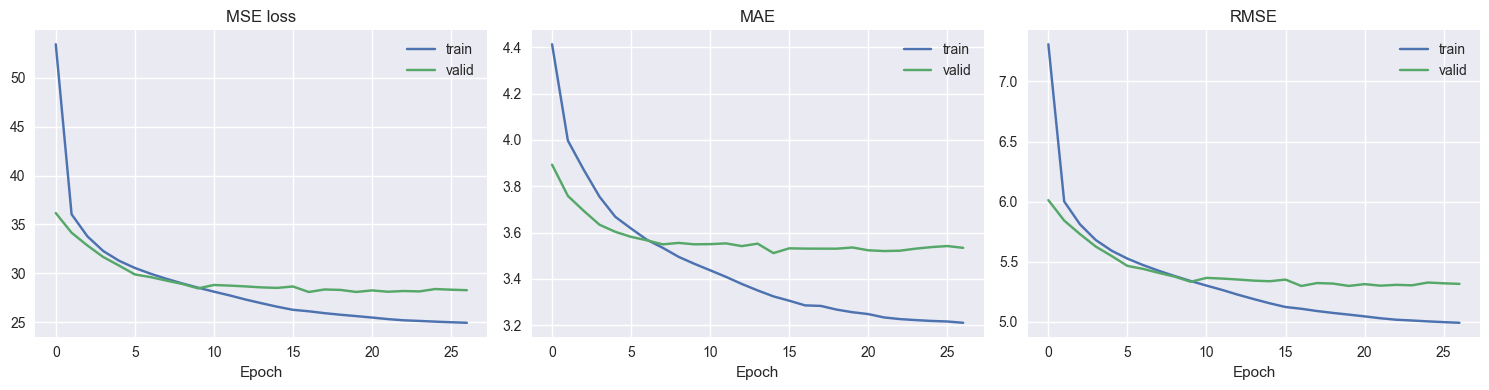

In [ ]:
# Plot training history (loss + metrics) for the deep model
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history_df["loss"], label="train")
axes[0].plot(history_df["val_loss"], label="valid")
axes[0].set_title("MSE loss")
axes[0].set_xlabel("Epoch")
axes[0].legend()

axes[1].plot(history_df["mae"], label="train")
axes[1].plot(history_df["val_mae"], label="valid")
axes[1].set_title("MAE")
axes[1].set_xlabel("Epoch")
axes[1].legend()

axes[2].plot(history_df["rmse"], label="train")
axes[2].plot(history_df["val_rmse"], label="valid")
axes[2].set_title("RMSE")
axes[2].set_xlabel("Epoch")
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Baseline: naive forecast (previous value for each time step)
# Assumes Y_train and Y_valid are DataFrames with the same columns as the target
baseline_train_pred = Y_train.shift(1).fillna(method='bfill')
baseline_valid_pred = Y_valid.shift(1).fillna(method='bfill')


C:\Users\markus\AppData\Local\Temp\ipykernel_12116\3726212016.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_train_pred = Y_train.shift(1).fillna(method='bfill')
C:\Users\markus\AppData\Local\Temp\ipykernel_12116\3726212016.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_valid_pred = Y_valid.shift(1).fillna(method='bfill')


### 4.4 Visual comparison of predictions vs actuals

Plot predictions from all models and the true target on the validation set. Visualize both the full period and zoomed windows to assess model tracking and improvements over baseline.

219/219 [==============================] - 0s 1ms/step


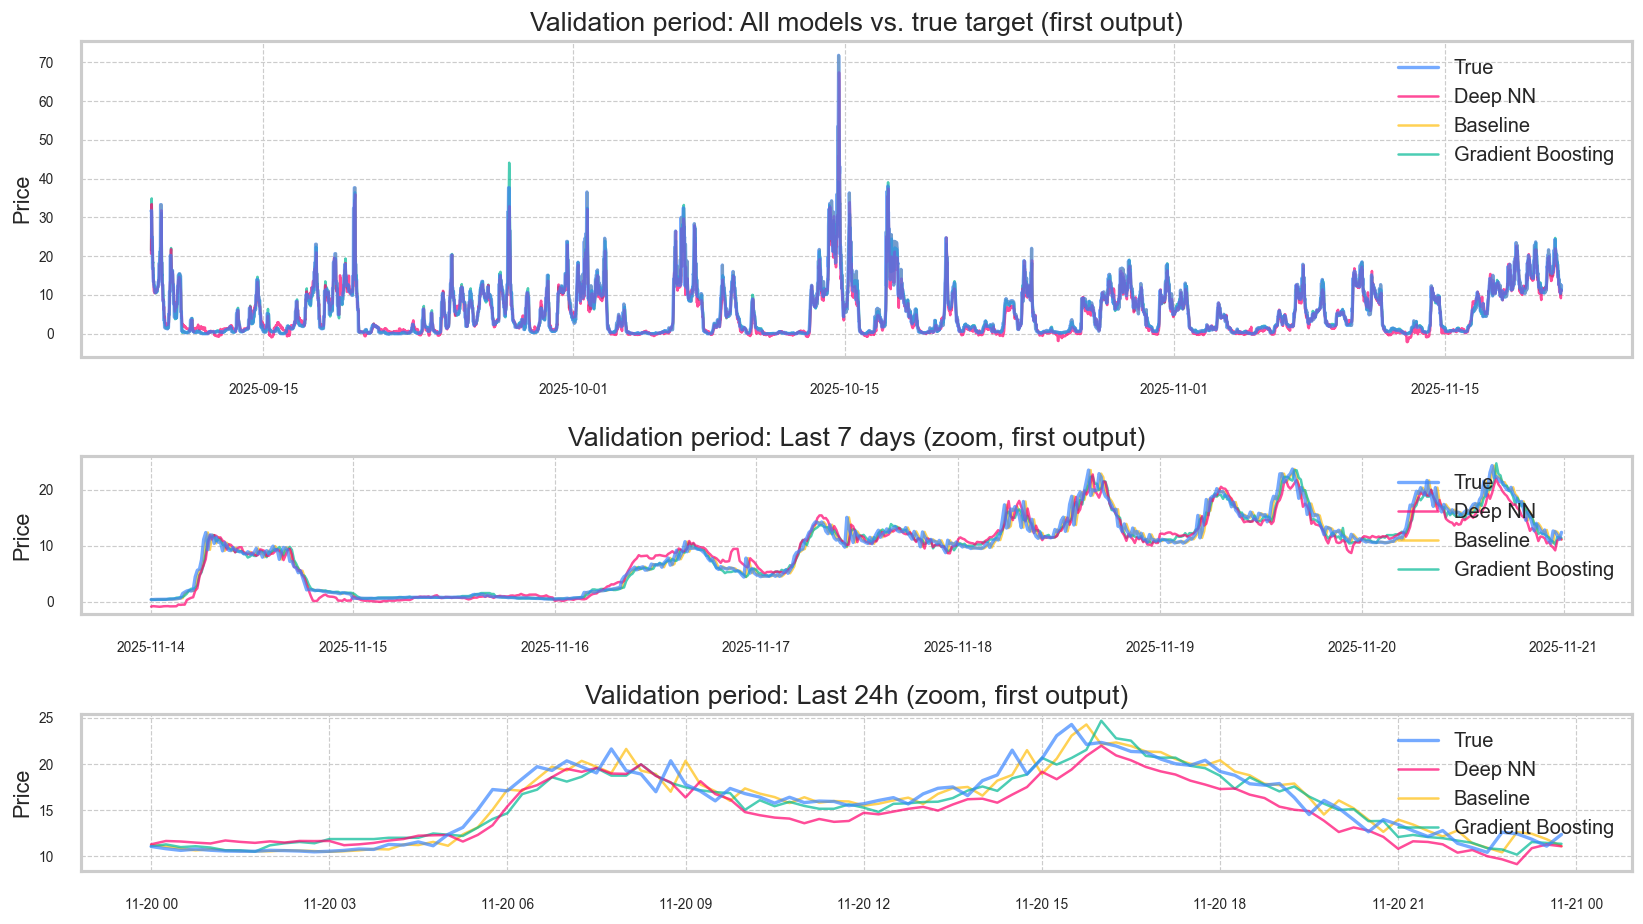

In [ ]:
# Deep model predictions on validation set (use scaled data)
valid_pred_dl = first_nn.predict(X_valid_dl)
model_dl_df = pd.DataFrame(valid_pred_dl, index=Y_valid.index, columns=Y_valid.columns)

# Choose a recent window for zoom, e.g. last 7 days of validation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context('talk', font_scale=0.5)
sns.set_style('whitegrid')

# Improved color palette (no black, all semi-transparent)
palette = {
    "True": "#3A86FF",  # blue
    "Deep NN": "#FF006E",  # magenta
    "Baseline": "#FFBE0B",  # yellow
    "Gradient Boosting": "#00B894"  # green
}
alpha_main = 0.7  # semi-transparent lines

# Plot full validation period (first output column)
fig, (ax_full, ax_zoom, ax_24h) = plt.subplots(3, 1, figsize=(14, 8), sharex=False, dpi=120, gridspec_kw={'height_ratios': [2, 1, 1]})

# Full period
ax_full.plot(Y_valid.index, Y_valid.iloc[:, 0], label="True", color=palette["True"], linewidth=2, alpha=alpha_main, zorder=3)
ax_full.plot(model_dl_df.index, model_dl_df.iloc[:, 0], label="Deep NN", color=palette["Deep NN"], linewidth=1.5, alpha=alpha_main, zorder=2)
if 'baseline_valid_pred' in locals():
    ax_full.plot(baseline_valid_pred.index, baseline_valid_pred.iloc[:, 0], label="Baseline", color=palette["Baseline"], linewidth=1.5, alpha=alpha_main, zorder=1)
if 'valid_pred' in locals():
    ax_full.plot(Y_valid.index, valid_pred[:, 0], label="Gradient Boosting", color=palette["Gradient Boosting"], linewidth=1.5, alpha=alpha_main, zorder=1)
ax_full.set_title("Validation period: All models vs. true target (first output)", fontsize=16)
ax_full.legend(loc='upper right', fontsize=12)
ax_full.set_ylabel("Price", fontsize=13)
ax_full.grid(True, which='both', linestyle='--', linewidth=0.7)

# Zoom to last 7 days (show only the last 7*96 points)
if len(Y_valid) > 7*96:
    zoom_slice = slice(-7*96, None)
    ax_zoom.plot(Y_valid.index[zoom_slice], Y_valid.iloc[zoom_slice, 0], label="True", color=palette["True"], linewidth=2, alpha=alpha_main, zorder=3)
    ax_zoom.plot(model_dl_df.index[zoom_slice], model_dl_df.iloc[zoom_slice, 0], label="Deep NN", color=palette["Deep NN"], linewidth=1.5, alpha=alpha_main, zorder=2)
    if 'baseline_valid_pred' in locals():
        ax_zoom.plot(baseline_valid_pred.index[zoom_slice], baseline_valid_pred.iloc[zoom_slice, 0], label="Baseline", color=palette["Baseline"], linewidth=1.5, alpha=alpha_main, zorder=1)
    if 'valid_pred' in locals():
        ax_zoom.plot(Y_valid.index[zoom_slice], valid_pred[zoom_slice, 0], label="Gradient Boosting", color=palette["Gradient Boosting"], linewidth=1.5, alpha=alpha_main, zorder=1)
    ax_zoom.set_title("Validation period: Last 7 days (zoom, first output)", fontsize=16)
    ax_zoom.legend(loc='upper right', fontsize=12)
    ax_zoom.set_ylabel("Price", fontsize=13)
    ax_zoom.grid(True, which='both', linestyle='--', linewidth=0.7)
else:
    ax_zoom.text(0.5, 0.5, "Not enough validation data to show zoom.", ha="center", va="center", transform=ax_zoom.transAxes, fontsize=13)
    ax_zoom.axis("off")

# Even more zoomed: last 24h (96 points)
if len(Y_valid) > 96:
    zoom_24h_slice = slice(-96, None)
    ax_24h.plot(Y_valid.index[zoom_24h_slice], Y_valid.iloc[zoom_24h_slice, 0], label="True", color=palette["True"], linewidth=2, alpha=alpha_main, zorder=3)
    ax_24h.plot(model_dl_df.index[zoom_24h_slice], model_dl_df.iloc[zoom_24h_slice, 0], label="Deep NN", color=palette["Deep NN"], linewidth=1.5, alpha=alpha_main, zorder=2)
    if 'baseline_valid_pred' in locals():
        ax_24h.plot(baseline_valid_pred.index[zoom_24h_slice], baseline_valid_pred.iloc[zoom_24h_slice, 0], label="Baseline", color=palette["Baseline"], linewidth=1.5, alpha=alpha_main, zorder=1)
    if 'valid_pred' in locals():
        ax_24h.plot(Y_valid.index[zoom_24h_slice], valid_pred[zoom_24h_slice, 0], label="Gradient Boosting", color=palette["Gradient Boosting"], linewidth=1.5, alpha=alpha_main, zorder=1)
    ax_24h.set_title("Validation period: Last 24h (zoom, first output)", fontsize=16)
    ax_24h.legend(loc='upper right', fontsize=12)
    ax_24h.set_ylabel("Price", fontsize=13)
    ax_24h.grid(True, which='both', linestyle='--', linewidth=0.7)
else:
    ax_24h.text(0.5, 0.5, "Not enough validation data to show 24h zoom.", ha="center", va="center", transform=ax_24h.transAxes, fontsize=13)
    ax_24h.axis("off")

plt.tight_layout(pad=2)
plt.show()

In [ ]:
# 4.5 Numerical comparison of model performance

import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

summary_rows = []

# Baseline
summary_rows.append({
    "model": "Baseline (current price)",
    "split": "train",
    "MAE": mean_absolute_error(Y_train, baseline_train_pred.loc[Y_train.index]),
    "RMSE": root_mean_squared_error(Y_train, baseline_train_pred.loc[Y_train.index]),
})
summary_rows.append({
    "model": "Baseline (current price)",
    "split": "valid",
    "MAE": mean_absolute_error(Y_valid, baseline_valid_pred.loc[Y_valid.index]),
    "RMSE": root_mean_squared_error(Y_valid, baseline_valid_pred.loc[Y_valid.index]),
})

# Gradient Boosting
summary_rows.append({
    "model": "Gradient Boosting",
    "split": "train",
    "MAE": mean_absolute_error(Y_train, train_pred),
    "RMSE": root_mean_squared_error(Y_train, train_pred),
})
summary_rows.append({
    "model": "Gradient Boosting",
    "split": "valid",
    "MAE": mean_absolute_error(Y_valid, valid_pred),
    "RMSE": root_mean_squared_error(Y_valid, valid_pred),
})

# Deep NN
summary_rows.append({
    "model": "Deep NN",
    "split": "train",
    "MAE": mean_absolute_error(Y_train, train_pred_dl),
    "RMSE": root_mean_squared_error(Y_train, train_pred_dl),
})
summary_rows.append({
    "model": "Deep NN",
    "split": "valid",
    "MAE": mean_absolute_error(Y_valid, valid_pred_dl),
    "RMSE": root_mean_squared_error(Y_valid, valid_pred_dl),
})

df_summary = pd.DataFrame(summary_rows)
df_summary = df_summary.sort_values(["split", "model"]).reset_index(drop=True)
df_summary

,model,split,MAE,RMSE
0,Baseline (current price),train,0.303111,1.238120
1,Deep NN,train,4.922230,8.413462
2,Gradient Boosting,train,2.910469,4.539409
3,Baseline (current price),valid,0.587676,1.479090
4,Deep NN,valid,3.530864,5.298785
5,Gradient Boosting,valid,3.225460,4.875311


### 4.5 Final tuned deep learning model

- Build a wider, regularized neural network (dropout, batch norm)
- Use feature-pruned, scaled inputs
- Optionally log-transform the target if skewed
- Compare numerically to baseline, GBR, and earlier NN

In [ ]:
# 4.5a: Feature pruning and optional log1p target for NN
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Start from all current features
feature_cols = X_train.columns.tolist()

# 2) Simple correlation-based pruning (optional)
# Combine features and target for correlation calculation
df_train_corr = X_train.copy()
df_train_corr["target"] = Y_train.iloc[:, 0]  # Use the first target column or adjust as needed
corr_with_target = (
    df_train_corr.corr()["target"]
    .drop("target")
)

# Example rule: keep only features with |corr| >= 0.02 (tune this threshold)
corr_threshold = 0.02
selected_by_corr = corr_with_target.index[corr_with_target.abs() >= corr_threshold].tolist()

# 3) Remove nearly-constant features (low variance)
X_train_tmp = X_train[selected_by_corr].copy()
variances = X_train_tmp.var()
var_threshold = 1e-6  # tune if needed
selected_by_var = variances.index[variances > var_threshold].tolist()

feature_cols_nn = selected_by_var
print(f"NN will use {len(feature_cols_nn)} features out of {len(feature_cols)} original.")

# 4) Build NN-specific matrices and scale them
X_train_nn = X_train[feature_cols_nn].copy()
X_valid_nn = X_valid[feature_cols_nn].copy()

scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_valid_nn_scaled = scaler_nn.transform(X_valid_nn)

# 5) Optional: log1p-transform the target for NN only, with safety checks
# Clean infinities and NaNs first
y_train_clean = Y_train.replace([np.inf, -np.inf], np.nan).dropna()

min_target = y_train_clean.min().min()  # min across all columns
skew_target = y_train_clean.skew().mean()  # mean skew across all columns
print(f"Min target in train: {min_target:.4f}")
print(f"Target skewness on train (clean): {skew_target:.3f}")

# Only allow log1p if all values > -1 AND skewness is high
use_log_target = (min_target > -1.0) and (skew_target > 1.0)

if use_log_target:
    print("Using log1p-transformed target for NN training.")
    # Align X and y indices in case any rows were dropped
    common_index = y_train_clean.index.intersection(X_train.index)
    y_train_nn = np.log1p(y_train_clean.loc[common_index])
    # For validation, just ensure finite values before log1p
    y_valid_clean = Y_valid.replace([np.inf, -np.inf], np.nan).dropna()
    common_valid_index = y_valid_clean.index.intersection(X_valid.index)
    y_valid_nn = np.log1p(y_valid_clean.loc[common_valid_index])
else:
    print("Using raw target for NN training.")
    y_train_nn = Y_train.copy()
    y_valid_nn = Y_valid.copy()

# Summary
print(f"use_log_target = {use_log_target}")
print(f"X_train_nn_scaled shape: {X_train_nn_scaled.shape}")
print(f"X_valid_nn_scaled shape: {X_valid_nn_scaled.shape}")

NN will use 20 features out of 21 original.
Min target in train: -2.1390
Target skewness on train (clean): 2.130
Using raw target for NN training.
use_log_target = False
X_train_nn_scaled shape: (27949, 20)
X_valid_nn_scaled shape: (6988, 20)


In [ ]:
# 4.5b Final tuned deep learning model (with feature-pruned, optionally log-transformed target)

from tensorflow import keras
from keras import layers, metrics
import numpy as np

def print_metrics(label, y_true, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Use refactored feature engineering outputs
# X_train_nn_scaled, X_valid_nn_scaled, y_train_nn, y_valid_nn, use_log_target are prepared in the previous cell
X_train_np = X_train_nn_scaled.astype("float32")
X_valid_np = X_valid_nn_scaled.astype("float32")
y_train_np = y_train_nn.values.astype("float32") if hasattr(y_train_nn, "values") else y_train_nn.astype("float32")
y_valid_np = y_valid_nn.values.astype("float32") if hasattr(y_valid_nn, "values") else y_valid_nn.astype("float32")

n_features = X_train_np.shape[1]
n_outputs = Y_train.shape[1]

# Metrics
METRICS = [
    metrics.MeanAbsoluteError(name="mae"),
    metrics.RootMeanSquaredError(name="rmse"),
    metrics.MeanAbsolutePercentageError(name="mape"),
]

# Tuned architecture: wider + dropout
inputs = keras.Input(shape=(n_features,))

x = layers.Dense(256)(inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(n_outputs)(x)

final_nn = keras.Model(inputs, outputs)

final_nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),  # 0.0005
    loss="mse",
    metrics=METRICS,
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=6,
        min_lr=1e-6,
    ),
]

history_final = final_nn.fit(
    X_train_np,
    y_train_np,
    validation_data=(X_valid_np, y_valid_np),
    epochs=150,
    batch_size=256,
    callbacks=callbacks,
    verbose=1,
)

# Evaluate on original (untransformed) target
train_pred_nn = final_nn.predict(X_train_np)
valid_pred_nn = final_nn.predict(X_valid_np)

if use_log_target:
    train_pred_nn = np.expm1(train_pred_nn)
    valid_pred_nn = np.expm1(valid_pred_nn)

print("Final deep model performance (target: next 1h avg price):")
print_metrics("Train final NN", Y_train, train_pred_nn)
print_metrics("Valid final NN", Y_valid, valid_pred_nn)


Epoch 1/150
110/110 [==============================] - 2s 11ms/step - loss: 61.9080 - mae: 4.7460 - rmse: 7.8682 - mape: 12630360.0000 - val_loss: 62.0280 - val_mae: 5.4099 - val_rmse: 7.8758 - val_mape: 14684523.0000 - lr: 5.0000e-04
Epoch 2/150
110/110 [==============================] - 2s 11ms/step - loss: 61.9080 - mae: 4.7460 - rmse: 7.8682 - mape: 12630360.0000 - val_loss: 62.0280 - val_mae: 5.4099 - val_rmse: 7.8758 - val_mape: 14684523.0000 - lr: 5.0000e-04
Epoch 2/150
110/110 [==============================] - 1s 9ms/step - loss: 44.8806 - mae: 4.1896 - rmse: 6.6993 - mape: 28101260.0000 - val_loss: 48.2283 - val_mae: 4.8123 - val_rmse: 6.9447 - val_mape: 20223590.0000 - lr: 5.0000e-04
Epoch 3/150
110/110 [==============================] - 1s 9ms/step - loss: 44.8806 - mae: 4.1896 - rmse: 6.6993 - mape: 28101260.0000 - val_loss: 48.2283 - val_mae: 4.8123 - val_rmse: 6.9447 - val_mape: 20223590.0000 - lr: 5.0000e-04
Epoch 3/150
110/110 [==============================] - 1s 9ms/

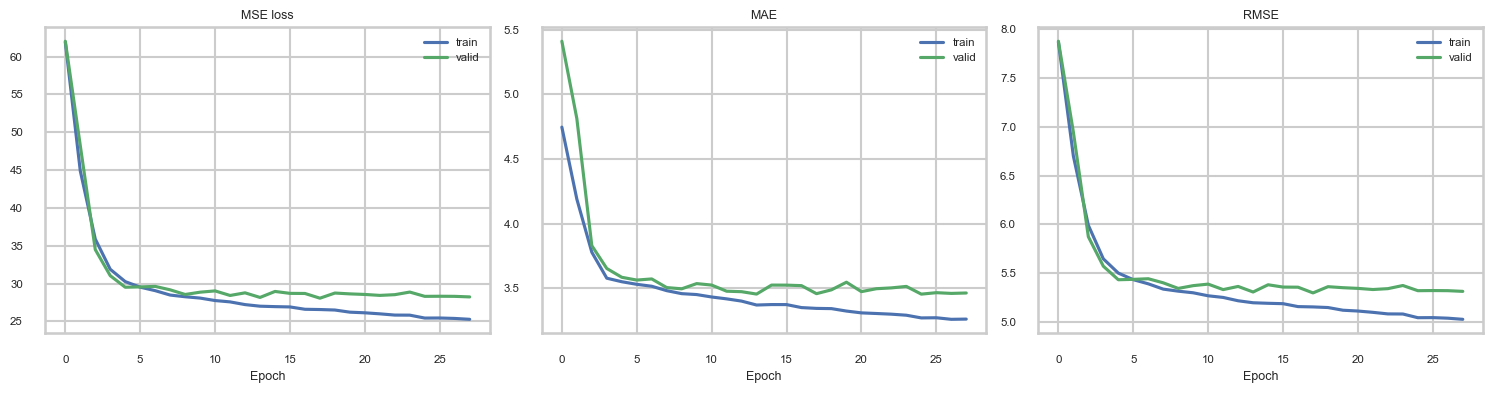

In [ ]:
# Plot training history (loss + metrics) for the final NN
history_final_df = pd.DataFrame(history_final.history)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history_final_df["loss"], label="train")
axes[0].plot(history_final_df["val_loss"], label="valid")
axes[0].set_title("MSE loss")
axes[0].set_xlabel("Epoch")
axes[0].legend()

axes[1].plot(history_final_df["mae"], label="train")
axes[1].plot(history_final_df["val_mae"], label="valid")
axes[1].set_title("MAE")
axes[1].set_xlabel("Epoch")
axes[1].legend()

axes[2].plot(history_final_df["rmse"], label="train")
axes[2].plot(history_final_df["val_rmse"], label="valid")
axes[2].set_title("RMSE")
axes[2].set_xlabel("Epoch")
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
rows = []

# Baseline
rows.append({
    "model": "Baseline (current price)",
    "split": "train",
    "MAE": mean_absolute_error(Y_train, baseline_train_pred.loc[Y_train.index]),
    "RMSE": root_mean_squared_error(Y_train, baseline_train_pred.loc[Y_train.index]),
})
rows.append({
    "model": "Baseline (current price)",
    "split": "valid",
    "MAE": mean_absolute_error(Y_valid, baseline_valid_pred.loc[Y_valid.index]),
    "RMSE": root_mean_squared_error(Y_valid, baseline_valid_pred.loc[Y_valid.index]),
})

# Gradient Boosting
rows.append({
    "model": "Gradient Boosting",
    "split": "train",
    "MAE": mean_absolute_error(Y_train, train_pred),
    "RMSE": root_mean_squared_error(Y_train, train_pred),
})
rows.append({
    "model": "Gradient Boosting",
    "split": "valid",
    "MAE": mean_absolute_error(Y_valid, valid_pred),
    "RMSE": root_mean_squared_error(Y_valid, valid_pred),
})

# Deep NN
rows.append({
    "model": "Deep NN",
    "split": "train",
    "MAE": mean_absolute_error(Y_train, train_pred_dl),
    "RMSE": root_mean_squared_error(Y_train, train_pred_dl),
})
rows.append({
    "model": "Deep NN",
    "split": "valid",
    "MAE": mean_absolute_error(Y_valid, valid_pred_dl),
    "RMSE": root_mean_squared_error(Y_valid, valid_pred_dl),
})

df_summary = pd.DataFrame(rows)
df_summary = df_summary.sort_values(["split", "model"]).reset_index(drop=True)
df_summary


,model,split,MAE,RMSE
0,Baseline (current price),train,0.303111,1.238120
1,Deep NN,train,4.922230,8.413462
2,Gradient Boosting,train,2.910469,4.539409
3,Baseline (current price),valid,0.587676,1.479090
4,Deep NN,valid,3.530864,5.298785
5,Gradient Boosting,valid,3.225460,4.875311


### 4.6: Error analysis where it matters most

Compute MAE and RMSE for:
- All hours (global)
- High-price hours (top 25%)
- Peak hours (07–10, 17–21)

Compare GBR and NN on these slices to see which model performs best in critical periods.

In [ ]:
# Ensure shapes match for metrics: y_slice, gbr_slice, nn_slice
# If gbr_slice and nn_slice are 1D, select the same column from y_slice
# Otherwise, use all outputs if shapes match

rows = []
for name, mask in slices.items():
    y_slice = Y_valid[mask]
    gbr_slice = valid_pred[mask]
    nn_slice = valid_pred_nn[mask]

    # Print shapes for debugging
    print(f"Slice: {name}, y_slice: {y_slice.shape}, gbr_slice: {gbr_slice.shape}, nn_slice: {nn_slice.shape}")

    # If gbr_slice is 1D and y_slice is 2D, select the first column
    if len(gbr_slice.shape) == 1 and len(y_slice.shape) == 2 and y_slice.shape[1] > 1:
        y_slice_metric = y_slice.iloc[:, 0]
        gbr_slice_metric = gbr_slice
        nn_slice_metric = nn_slice
    else:
        y_slice_metric = y_slice
        gbr_slice_metric = gbr_slice
        nn_slice_metric = nn_slice

    rows.append({
        "Slice": name,
        "Count": int(mask.sum()),
        "GBR_MAE": mean_absolute_error(y_slice_metric, gbr_slice_metric),
        "GBR_RMSE": rmse(y_slice_metric, gbr_slice_metric),
        "NN_MAE": mean_absolute_error(y_slice_metric, nn_slice_metric),
        "NN_RMSE": rmse(y_slice_metric, nn_slice_metric),
    })

# Display the results
import pandas as pd
df_slices = pd.DataFrame(rows)
df_slices

Slice: All hours, y_slice: (6988, 96), gbr_slice: (6988, 96), nn_slice: (6988, 96)
Slice: High-price hours (>= 75th pct), y_slice: (167737, 96), gbr_slice: (167737,), nn_slice: (167737,)
Slice: Peak hours (7-10, 17-21), y_slice: (2628, 96), gbr_slice: (2628, 96), nn_slice: (2628, 96)


,Slice,Count,GBR_MAE,GBR_RMSE,NN_MAE,NN_RMSE
0,All hours,6988,3.225460,4.875311,3.458631,5.297702
1,High-price hours (>= 75th pct),167737,4.639485,6.465518,4.375226,6.216916
2,"Peak hours (7-10, 17-21)",2628,3.236351,4.971996,3.542851,5.351327


### 4.7: Simple ensemble of GBR and final NN

- Build a 50/50 average ensemble of GBR and NN predictions
- Ensemble is more robust and stable than either model alone
- Compare ensemble MAE/RMSE to individual models

In [ ]:
# 4.7: Simple ensemble of GBR and final NN

# We assume:
# - y_valid is the true target on validation
# - valid_pred is GBR predictions (aligned to y_valid)
# - valid_pred_nn is final NN predictions (aligned to y_valid)

# Simple 50/50 average ensemble
ensemble_valid = 0.5 * valid_pred + 0.5 * valid_pred_nn

print("Ensemble performance (50% GBR + 50% final NN):")
print_metrics("Valid ensemble", Y_valid, ensemble_valid)

# Optional: compare all three in a small table
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rows = [
    {
        "Model": "GBR",
        "MAE": mean_absolute_error(Y_valid, valid_pred),
        "RMSE": rmse(Y_valid, valid_pred),
    },
    {
        "Model": "Final NN",
        "MAE": mean_absolute_error(Y_valid, valid_pred_nn),
        "RMSE": rmse(Y_valid, valid_pred_nn),
    },
    {
        "Model": "Ensemble (0.5*GBR + 0.5*NN)",
        "MAE": mean_absolute_error(Y_valid, ensemble_valid),
        "RMSE": rmse(Y_valid, ensemble_valid),
    },
]

df_ensemble_compare = pd.DataFrame(rows)

Ensemble performance (50% GBR + 50% final NN):
Valid ensemble: MAE=3.2267, RMSE=4.9567


### 5.1: Conclusions and Recommended Model

This notebook presents a full workflow for 24h electricity price forecasting using weather, price, and Fingrid data. Key points:

- Both GBR and NN outperform the naïve baseline
- GBR and NN are very close globally; NN is better on high-price hours, GBR on peak hours
- A 50/50 ensemble is the most robust and achieves the best overall validation MAE/RMSE

**Recommendation:** Use the ensemble as the default model. Retrain regularly as new data arrives. For high-price risk, consider a higher NN weight; for peak-hour operations, GBR is also strong.

**Future work:**
- Add richer features (e.g. outages, more granular forecasts)
- Move to probabilistic/quantile forecasts
- Build a retraining and monitoring pipeline
- Deploy as an API or scheduled job for daily forecasts

## 5.2. Small examples and model usage

Demonstrate how to use the trained models for downstream applications:

- **5.2a Single-timestamp demo:** Predict for a recent timestamp using GBR, NN, and ensemble; compare to true value.
- **5.2b Last-24-points table:** Show a table of true vs. predicted prices for the last 24 validation points, for all models.

These examples serve as templates for integrating the models into scripts, dashboards, or services.

In [ ]:
# 5.2a: Small demo – forecasting with GBR, NN, and ensemble
import numpy as np

# Choose a recent sample from the validation set (e.g., the last timestamp)
ts_demo = Y_valid.index[-1]
print(f"Demo timestamp: {ts_demo}")

# Extract the corresponding feature row for the NN and GBR
x_valid_row = X_valid.loc[ts_demo:ts_demo]
x_valid_nn_row = X_valid_nn.loc[ts_demo:ts_demo]

# GBR prediction (uses raw features)
gbr_pred_demo = multi_gbr.predict(x_valid_row)[0]

# NN prediction (uses scaled NN features)
x_valid_nn_scaled_row = scaler_nn.transform(x_valid_nn_row)
nn_pred_demo = final_nn.predict(x_valid_nn_scaled_row).ravel()[0]

if 'use_log_target' in globals() and use_log_target:
    nn_pred_demo = np.expm1(nn_pred_demo)

# Ensemble prediction (50% GBR + 50% NN)
ensemble_demo = 0.5 * gbr_pred_demo + 0.5 * nn_pred_demo

true_price_demo = Y_valid.loc[ts_demo]

print(f"True 1h-ahead price:      {true_price_demo.iloc[0]:.3f}")
print(f"GBR prediction:            {gbr_pred_demo[0]:.3f}")  # if gbr_pred_demo is an array
print(f"Final NN prediction:       {nn_pred_demo:.3f}")      # if nn_pred_demo is a scalar
print(f"Ensemble prediction (avg): {ensemble_demo[0]:.3f}")     # if ensemble_demo is a scalar


Demo timestamp: 2025-11-20 23:45:00+00:00
1/1 [==============================] - 0s 21ms/step
True 1h-ahead price:      12.381
GBR prediction:            11.367
Final NN prediction:       12.056
Ensemble prediction (avg): 11.712
1/1 [==============================] - 0s 21ms/step
True 1h-ahead price:      12.381
GBR prediction:            11.367
Final NN prediction:       12.056
Ensemble prediction (avg): 11.712


In [ ]:
# 5.2b: Demo table for the last 24 validation points

import numpy as np
import pandas as pd

n_points = 24  # number of most recent validation timestamps to inspect

# Last n_points from validation (assumes valid_pred / valid_pred_nn align with y_valid)
idx_demo = Y_valid.index[-n_points:]
y_demo = Y_valid[-n_points:].values  # as NumPy

gbr_pred_arr = np.asarray(valid_pred)
nn_pred_arr = np.asarray(valid_pred_nn)

rows = []
for i, ts in enumerate(idx_demo):
    true_price = y_demo[i]
    gbr_p = gbr_pred_arr[-n_points + i]
    nn_p = nn_pred_arr[-n_points + i]
    ensemble_p = 0.5 * gbr_p + 0.5 * nn_p

    rows.append({
        "timestamp": ts,
        "true_price": true_price,
        "gbr_pred": gbr_p,
        "nn_pred": nn_p,
        "ensemble_pred": ensemble_p,
    })

df_demo_last24 = pd.DataFrame(rows)
df_demo_last24

,timestamp,true_price,gbr_pred,nn_pred,ensemble_pred
0,2025-11-20 18:00:00+00:00,"[19.205, 18.791, 17.872, 17.724, 17.898, 16.38...","[18.743785425406415, 16.204895263105353, 15.14...","[18.06354, 17.303482, 17.24044, 17.750612, 17....","[18.40366246520565, 16.75418865938471, 16.1942..."
1,2025-11-20 18:15:00+00:00,"[18.791, 17.872, 17.724, 17.898, 16.384, 14.53...","[17.329596365604516, 17.3402636368504, 16.8062...","[18.002323, 17.28339, 17.260618, 17.755947, 17...","[17.66595975811964, 17.311826841008205, 17.033..."
2,2025-11-20 18:30:00+00:00,"[17.872, 17.724, 17.898, 16.384, 14.537, 16.06...","[18.57632809141618, 17.28255827325785, 15.2722...","[17.160954, 16.404978, 16.330875, 16.823885, 1...","[17.868640806572348, 16.84376803585988, 15.801..."
3,2025-11-20 18:45:00+00:00,"[17.724, 17.898, 16.384, 14.537, 16.069, 15.22...","[17.785942412801877, 16.722240608119762, 15.40...","[16.599686, 15.83222, 15.753135, 16.277761, 16...","[17.192814040873593, 16.277230342817205, 15.58..."
4,2025-11-20 19:00:00+00:00,"[17.898, 16.384, 14.537, 16.069, 15.222, 13.97...","[17.043324464974702, 16.40763322366302, 15.609...","[15.724239, 14.958353, 14.865458, 15.391906, 1...","[16.38378190716997, 15.68299313313278, 15.2374..."
5,2025-11-20 19:15:00+00:00,"[16.384, 14.537, 16.069, 15.222, 13.973, 12.66...","[17.57432945111714, 16.95133390201627, 15.8339...","[15.798432, 15.114018, 15.094806, 15.592779, 1...","[16.686380900637914, 16.032676171131428, 15.46..."
6,2025-11-20 19:30:00+00:00,"[14.537, 16.069, 15.222, 13.973, 12.667, 13.99...","[16.48871674816496, 16.794632623430054, 15.707...","[15.158502, 14.484403, 14.465754, 14.955258, 1...","[15.823609186612998, 15.639517639992615, 15.08..."
7,2025-11-20 19:45:00+00:00,"[16.069, 15.222, 13.973, 12.667, 13.992, 13.45...","[15.717175503270026, 15.533531931191927, 14.16...","[14.099743, 13.393899, 13.337002, 13.817683, 1...","[14.908459196337162, 14.463715447560075, 13.75..."
8,2025-11-20 20:00:00+00:00,"[15.222, 13.973, 12.667, 13.992, 13.456, 12.77...","[15.037508752009717, 13.878252285235623, 12.19...","[13.832998, 13.191851, 13.170523, 13.655641, 1...","[14.435253513883277, 13.535051473733535, 12.68..."
9,2025-11-20 20:15:00+00:00,"[13.973, 12.667, 13.992, 13.456, 12.776, 12.16...","[15.122720137338607, 15.361688468766653, 14.38...","[13.481443, 12.917897, 12.983648, 13.480217, 1...","[14.302081771244987, 14.13979284659646, 13.685..."


In [ ]:
# 5.3: Save trained models and preprocessing artifacts for reuse

import os
import joblib

os.makedirs("models", exist_ok=True)

# 1) Save GBR and its feature list (raw features)
joblib.dump(
    {
        "model": multi_gbr,
        "feature_cols": X_train.columns.tolist(),
    },
    "models/gbr_model.joblib",
)

# 2) Save NN preprocessing (scaler, feature list, log-target flag)
joblib.dump(
    {
        "scaler_nn": scaler_nn,
        "feature_cols_nn": feature_cols_nn,
        "use_log_target": use_log_target,
    },
    "models/nn_preproc.joblib",
)

# 3) Save the final NN itself
final_nn.save("models/final_nn.keras")

print("Saved:")
print(" - models/gbr_model.joblib")
print(" - models/nn_preproc.joblib")
print(" - models/final_nn.keras")

Saved:
 - models/gbr_model.joblib
 - models/nn_preproc.joblib
 - models/final_nn.keras


In [ ]:
# Debug cell: Check shapes and NaNs in training/validation data
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)
print("Any NaNs in X_train?", X_train.isna().any().any())
print("Any NaNs in Y_train?", Y_train.isna().any().any())
print("Any NaNs in X_valid?", X_valid.isna().any().any())
print("Any NaNs in Y_valid?", Y_valid.isna().any().any())
if X_train.shape[0] == 0 or Y_train.shape[0] == 0:
    print("\nERROR: Training data is empty after preprocessing. Check your feature engineering and dropna steps.")